In [ ]:
# https://www.kaggle.com/datasets/adityavahreza/cat-skin-disease-v2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 200
BATCH_SIZE = 15
CHANNELS = 3
EPOCHS = 75

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Machine_Learning/PetBuddy_2ndYrDesignLab_imageModel/cat/data',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1019 files belonging to 4 classes.


In [ ]:
dataset.class_names

['Flea_Allergy', 'Health', 'Ringworm', 'Scabies']

In [ ]:
train_split = 0.75
val_split = 0.15
test_split = 0.1

train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size).skip(val_size)

In [ ]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
len(dataset), len(train_ds), len(val_ds), len(test_ds)

(68, 51, 10, 7)

In [ ]:
import os

save_base_dir = '/content/drive/MyDrive/Machine_Learning/PetBuddy_2ndYrDesignLab_imageModel/cat/test_data/'
class_names = ['Flea_Allergy', 'Health', 'Ringworm', 'Scabies']

os.makedirs(save_base_dir, exist_ok=True)
counter_per_class = dict()

for batch_idx, (images, labels) in enumerate(test_ds):
    for idx in range(images.shape[0]):
        image = images[idx]
        label = labels[idx]

        class_name = class_names[label.numpy()]

        class_dir = os.path.join(save_base_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        count = counter_per_class.get(class_name, 0) + 1
        counter_per_class[class_name] = count
        img_filename = f"{class_name}_{count:03d}.jpg"
        img_save_path = os.path.join(class_dir, img_filename)

        image = tf.cast(image, tf.uint8)

        encoded_img = tf.io.encode_jpeg(image)
        tf.io.write_file(img_save_path, encoded_img)


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.30)
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((1, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (15, 200, 200, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (15, 198, 198, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (15, 99, 99, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (15, 97, 97, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (15, 48, 48, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (15, 46, 46, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (15, 23, 23, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (15, 21, 21, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (15, 21, 21, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (15, 28224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (15, 64)                    │       1,806,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (15, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,899,908 (7.25 MB)

 Trainable params: 1,899,908 (7.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.2300 - loss: 1.6308 - val_accuracy: 0.3467 - val_loss: 1.3860
Epoch 2/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.2655 - loss: 1.3866 - val_accuracy: 0.2267 - val_loss: 1.3852
Epoch 3/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.2492 - loss: 1.3765 - val_accuracy: 0.2933 - val_loss: 1.3640
Epoch 4/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.3814 - loss: 1.3220 - val_accuracy: 0.3800 - val_loss: 1.3343
Epoch 5/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.3777 - loss: 1.3182 - val_accuracy: 0.4733 - val_loss: 1.2452
Epoch 6/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.4818 - loss: 1.2201 - val_accuracy: 0.4467 - val_loss: 1.1586
Epoch 7/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.4504 - loss: 1.1535 - val_accuracy: 0.5200 - val_loss: 1.1352
Epoch 8/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.4864 - loss: 1.1439 - val_accuracy: 0.4733

In [ ]:
scores = model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7264 - loss: 1.4802


In [ ]:
model.save("/content/drive/MyDrive/Machine_Learning/PetBuddy_2ndYrDesignLab_imageModel/cat/cat_model.h5")

In [ ]:
import numpy as np
model = tf.keras.models.load_model('/content/drive/MyDrive/Machine_Learning/PetBuddy_2ndYrDesignLab_imageModel/cat/cat_model.h5')

class_names = ['Flea_Allergy', 'Health', 'Ringworm', 'Scabies']

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    # print(np.argmax(predictions[0]))
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

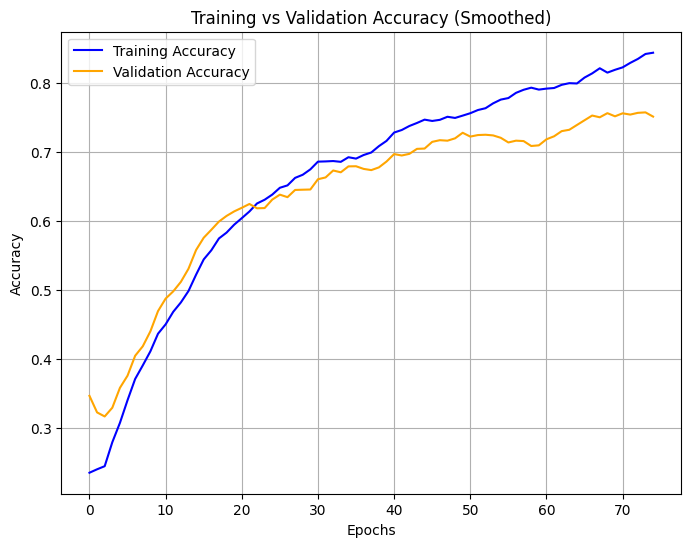

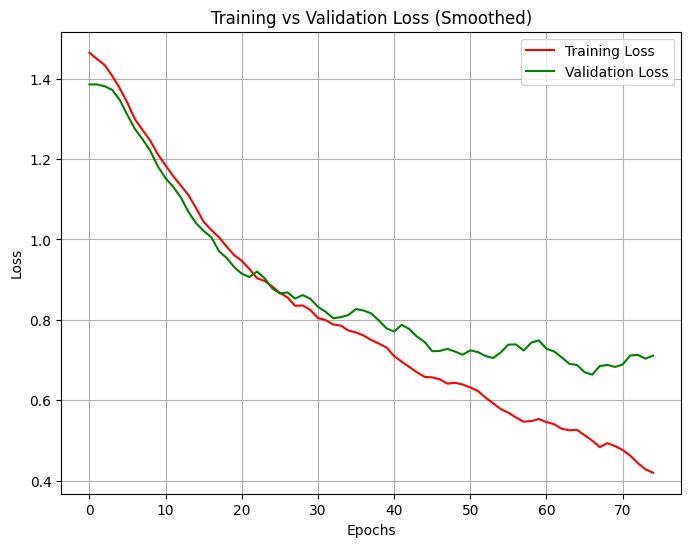

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Accuracy
plt.figure(figsize=(8, 6))
plt.plot(smooth_curve(history.history['accuracy']), label='Training Accuracy', color='blue')
plt.plot(smooth_curve(history.history['val_accuracy']), label='Validation Accuracy', color='orange')
plt.title('Training vs Validation Accuracy (Smoothed)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8, 6))
plt.plot(smooth_curve(history.history['loss']), label='Training Loss', color='red')
plt.plot(smooth_curve(history.history['val_loss']), label='Validation Loss', color='green')
plt.title('Training vs Validation Loss (Smoothed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
